# Bitcoin Price Predictive Analytics

## 1. Import Library

In [1]:
# Library untuk processing and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import zipfile
%matplotlib inline

# Library untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Library untuk model XGBoost dan hyperparameter tuning
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Library untuk evaluasi model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Untuk mengabaikan warning yang tidak penting
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data

Dataset yang digunakan didapatkan dari kaggle dengan rentang waktu dari 13 April 2013 - 7 Juli 2021 dan dari coinmarketcap dari 8 Juli 2021 - 19 Oktober 2024. Nantinya akan dilakukan preprocessing dan merge dari kedua dataset tersebut

### Dataset Kaggle

In [2]:
!kaggle datasets download -d sudalairajkumar/cryptocurrencypricehistory

with zipfile.ZipFile("cryptocurrencypricehistory.zip", 'r') as zip_ref:
    zip_ref.extractall("crypto_data")

os.listdir("crypto_data")

Dataset URL: https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory
License(s): CC0-1.0
  0% 0.00/1.70M [00:00<?, ?B/s]
100% 1.70M/1.70M [00:00<00:00, 144MB/s]


['coin_Monero.csv',
 'coin_USDCoin.csv',
 'coin_Stellar.csv',
 'coin_Solana.csv',
 'coin_Aave.csv',
 'coin_Uniswap.csv',
 'coin_Litecoin.csv',
 'coin_Ethereum.csv',
 'coin_Cardano.csv',
 'coin_CryptocomCoin.csv',
 'coin_Bitcoin.csv',
 'coin_BinanceCoin.csv',
 'coin_Tether.csv',
 'coin_Dogecoin.csv',
 'coin_Polkadot.csv',
 'coin_Cosmos.csv',
 'coin_ChainLink.csv',
 'coin_Iota.csv',
 'coin_XRP.csv',
 'coin_NEM.csv',
 'coin_Tron.csv',
 'coin_WrappedBitcoin.csv',
 'coin_EOS.csv']

In [3]:
btc_kg_df = pd.read_csv("/content/crypto_data/coin_Bitcoin.csv")
print('Shape of Kaggle Bitcoin dataset: ',btc_kg_df.shape)

btc_kg_df

Shape of Kaggle Bitcoin dataset:  (2991, 10)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


Output kode di atas memberikan informasi sebagai berikut:
- Dataset berjumlah 2991 baris (records)
- Terdapat 10 kolom yaitu SNo, Name, Symbol, Date, High, Low, Open, Close, Volume, dan Marketcap.

### Dataset CoinMarketCap

In [4]:
def clean_and_merge_datasets(file_paths):
    dataframes = []

    for file in file_paths:
        df = pd.read_csv(file, sep=';')
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        dataframes.append(df)

    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df = merged_df.sort_values(by='timestamp', ascending=True)
    merged_df.reset_index(drop=True, inplace=True)

    def format_price(value):
        return f'{value:.6f}'

    price_columns = ['open', 'high', 'low', 'close']
    merged_df[price_columns] = merged_df[price_columns].applymap(format_price)

    merged_df['volume'] = merged_df['volume'].apply(lambda x: f'{x:.6e}')
    merged_df['marketCap'] = merged_df['marketCap'].apply(lambda x: f'{x:.6e}')

    return merged_df

In [5]:
file_paths = [
    '/content/Bitcoin_7_7_2021-12_31_2021_historical_data_coinmarketcap.csv',
    '/content/Bitcoin_12_31_2021-12_31_2022_historical_data_coinmarketcap.csv',
    '/content/Bitcoin_12_31_2022-12_31_2023_historical_data_coinmarketcap.csv',
    '/content/Bitcoin_12_31_2023-10_20_2024_historical_data_coinmarketcap.csv'
]

cmk_df = clean_and_merge_datasets(file_paths)

In [6]:
print('Shape of CoinMarketCap Bitcoin dataset: ',cmk_df.shape)
cmk_df

Shape of CoinMarketCap Bitcoin dataset:  (1200, 12)


,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2021-07-08T00:00:00.000Z,2021-07-08T23:59:59.999Z,2021-07-08T00:02:03.000Z,2021-07-08T11:05:03.000Z,2781,33889.606347,33907.908049,32133.182727,32877.372628,2.991040e+10,6.164929e+11,2021-07-08 23:59:59.999000+00:00
1,2021-07-09T00:00:00.000Z,2021-07-09T23:59:59.999Z,2021-07-09T22:43:03.000Z,2021-07-09T01:13:03.000Z,2781,32861.671294,34042.291771,32318.880358,33798.010207,2.743602e+10,6.337841e+11,2021-07-09 23:59:59.999000+00:00
2,2021-07-10T00:00:00.000Z,2021-07-10T23:59:59.999Z,2021-07-10T00:44:03.000Z,2021-07-10T20:17:03.000Z,2781,33811.243020,34209.070197,33116.013106,33520.519953,2.297187e+10,6.286153e+11,2021-07-10 23:59:59.999000+00:00
3,2021-07-11T00:00:00.000Z,2021-07-11T23:59:59.999Z,2021-07-11T22:02:03.000Z,2021-07-11T04:32:03.000Z,2781,33509.077262,34584.704550,33346.737722,34240.187011,2.010873e+10,6.421381e+11,2021-07-11 23:59:59.999000+00:00
4,2021-07-12T00:00:00.000Z,2021-07-12T23:59:59.999Z,2021-07-12T04:23:03.000Z,2021-07-12T20:07:03.000Z,2781,34254.016595,34592.155604,32697.308651,33155.848131,2.432150e+10,6.218280e+11,2021-07-12 23:59:59.999000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2024-10-15T00:00:00.000Z,2024-10-15T23:59:59.999Z,2024-10-15T14:02:00.000Z,2024-10-15T15:09:00.000Z,2781,66050.368727,67881.679587,64809.196947,67041.107165,4.886387e+10,1.325307e+12,2024-10-15 23:59:59.999000+00:00
1196,2024-10-16T00:00:00.000Z,2024-10-16T23:59:59.999Z,2024-10-16T11:48:00.000Z,2024-10-16T01:12:00.000Z,2781,67042.461822,68375.292949,66758.725509,67612.720778,3.819519e+10,1.336697e+12,2024-10-16 23:59:59.999000+00:00
1197,2024-10-17T00:00:00.000Z,2024-10-17T23:59:59.999Z,2024-10-17T00:38:00.000Z,2024-10-17T13:37:00.000Z,2781,67617.079571,67912.207640,66647.391211,67399.833492,3.279090e+10,1.332817e+12,2024-10-17 23:59:59.999000+00:00
1198,2024-10-18T00:00:00.000Z,2024-10-18T23:59:59.999Z,2024-10-18T18:47:00.000Z,2024-10-18T00:57:00.000Z,2781,67419.108725,68969.746924,67177.818199,68418.789049,3.685717e+10,1.352611e+12,2024-10-18 23:59:59.999000+00:00


Output kode di atas memberikan informasi sebagai berikut:

Dataset berjumlah 1200 baris (records)
Terdapat 12 kolom yaitu timeOpen, timeClose, timeHigh, timeLow, name, open, high, low, close, volume, marketCap, timestamp.

## 3. Exploratory Data Analysis

### Mengupas Informasi Dataset

In [7]:
btc_kg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 233.8+ KB


Berdasarkan informasi di atas, dataset memiliki beberapa kriteria sebagai berikut:
- 6 Kolom dengan tipe float64 yaitu High, Low, Open, Close, Volume, dan Marketcap
- 1 Kolom dengan tipe int64 yaitu SNo
- 3 Kolom dengan tipe object yaitu Name, Symbol, dan Date

In [8]:
cmk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timeOpen   1200 non-null   object             
 1   timeClose  1200 non-null   object             
 2   timeHigh   1200 non-null   object             
 3   timeLow    1200 non-null   object             
 4   name       1200 non-null   int64              
 5   open       1200 non-null   object             
 6   high       1200 non-null   object             
 7   low        1200 non-null   object             
 8   close      1200 non-null   object             
 9   volume     1200 non-null   object             
 10  marketCap  1200 non-null   object             
 11  timestamp  1200 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(10)
memory usage: 112.6+ KB


Berdasarkan informasi di atas, dataset memiliki beberapa kriteria sebagai berikut:
- 10 Kolom dengan tipe object yaitu timeOpen, timeClose, timeHigh, timeLow, open, high, low, close, volume, marketCap
- 1 Kolom dengan tipe datetime[ns, UTC] yaitu timestamp
- 1 Kolom dengan tipe int64 yaitu name

In [9]:
btc_kg_df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


In [10]:
cmk_df.describe()

,name
count,1200.0
mean,2781.0
std,0.0
min,2781.0
25%,2781.0
50%,2781.0
75%,2781.0
max,2781.0


Fungsi describe() di atas memberi informasi statistik pada masing-masing kolom di kedua dataset, antara lain:

- Count adalah jumlah sampel pada data
- Mean adalah nilai rata-rata
- Std adalah standar deviasi
- Min yaitu nilai minimum setiap kolom
- 25% adalah kuartil pertama, Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- 50% adalah kuartil kedua, atau biasa juga disebut median
- 75% adalah kuartil ketiga
- Max adalah nilai maksimum

In [11]:
btc_kg_df.isna().sum()

,0
SNo,0
Name,0
Symbol,0
Date,0
High,0
Low,0
Open,0
Close,0
Volume,0
Marketcap,0


In [12]:
cmk_df.isna().sum()

,0
timeOpen,0
timeClose,0
timeHigh,0
timeLow,0
name,0
open,0
high,0
low,0
close,0
volume,0


Berdasarkan kode di atas, kedua dataset tidak memiliki missing value.

<br>

### Merge Dataset

Sebelum masuk ke visualisasi data, akan dilakukan merging terlebih dahulu pada kedua dataset dan hanya akan menggunakan kolom date, high, low, open, close, volume, dan marketcap dari masing masing dataset, selain dari itu akan dihapus karena tidak relevan dengan pengembangan model. Nama kolom di kedua dataset juga akan diubah menjadi lower case serta dengan urutan yang sama.



In [13]:
btc_kg_df.drop(columns=['SNo', 'Name', 'Symbol'], inplace=True)
btc_kg_df.columns = btc_kg_df.columns.str.lower()

btc_kg_df

,date,high,low,open,close,volume,marketcap
0,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...
2986,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [14]:
cmk_df.columns = cmk_df.columns.str.lower()
cmk_df.drop(['timeopen', 'timeclose', 'name', 'timehigh', 'timelow'], axis=1, inplace=True)

cmk_df['timestamp'] = cmk_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
cmk_df.rename(columns={'timestamp': 'date'}, inplace=True)

cmk_df = cmk_df[['date', 'high', 'low', 'open', 'close', 'volume', 'marketcap']]

Untuk dataset dari coinmarketcap, karena kolom timeOpen, timeClose, timeHigh, timeLow, dan timestamp terjadi di 1 periode waktu yang sama yaitu dalam rentang 24 jam, maka hanya kolom timestamp yang akan digunakan untuk menggambarkan waktu dan disesuaikan formatnya seperti kolom 'date' di dataset kaggle.

In [15]:
cmk_df

,date,high,low,open,close,volume,marketcap
0,2021-07-08 23:59:59,33907.908049,32133.182727,33889.606347,32877.372628,2.991040e+10,6.164929e+11
1,2021-07-09 23:59:59,34042.291771,32318.880358,32861.671294,33798.010207,2.743602e+10,6.337841e+11
2,2021-07-10 23:59:59,34209.070197,33116.013106,33811.243020,33520.519953,2.297187e+10,6.286153e+11
3,2021-07-11 23:59:59,34584.704550,33346.737722,33509.077262,34240.187011,2.010873e+10,6.421381e+11
4,2021-07-12 23:59:59,34592.155604,32697.308651,34254.016595,33155.848131,2.432150e+10,6.218280e+11
...,...,...,...,...,...,...,...
1195,2024-10-15 23:59:59,67881.679587,64809.196947,66050.368727,67041.107165,4.886387e+10,1.325307e+12
1196,2024-10-16 23:59:59,68375.292949,66758.725509,67042.461822,67612.720778,3.819519e+10,1.336697e+12
1197,2024-10-17 23:59:59,67912.207640,66647.391211,67617.079571,67399.833492,3.279090e+10,1.332817e+12
1198,2024-10-18 23:59:59,68969.746924,67177.818199,67419.108725,68418.789049,3.685717e+10,1.352611e+12


In [16]:
btc_kg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2991 non-null   object 
 1   high       2991 non-null   float64
 2   low        2991 non-null   float64
 3   open       2991 non-null   float64
 4   close      2991 non-null   float64
 5   volume     2991 non-null   float64
 6   marketcap  2991 non-null   float64
dtypes: float64(6), object(1)
memory usage: 163.7+ KB


In [17]:
cmk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1200 non-null   object
 1   high       1200 non-null   object
 2   low        1200 non-null   object
 3   open       1200 non-null   object
 4   close      1200 non-null   object
 5   volume     1200 non-null   object
 6   marketcap  1200 non-null   object
dtypes: object(7)
memory usage: 65.8+ KB


Nampak bahwa tipe data untuk kolom high, low, open, close, volume, dan marketcap berbeda di kedua dataset, maka dari itu disamakan terlebih dahulu sebelum dimerge.

In [18]:
cols_to_convert = ['high', 'low', 'open', 'close', 'volume', 'marketcap']
cmk_df[cols_to_convert] = cmk_df[cols_to_convert].astype(float)

In [19]:
cmk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1200 non-null   object 
 1   high       1200 non-null   float64
 2   low        1200 non-null   float64
 3   open       1200 non-null   float64
 4   close      1200 non-null   float64
 5   volume     1200 non-null   float64
 6   marketcap  1200 non-null   float64
dtypes: float64(6), object(1)
memory usage: 65.8+ KB


In [20]:
# Menggabungkan kedua dataframe
mrg_df = pd.concat([btc_kg_df, cmk_df], ignore_index=True)
mrg_df.sort_values(by='date', ascending=True, inplace=True)
mrg_df.reset_index(drop=True, inplace=True)

In [21]:
print('Shape of merged dataset: ',mrg_df.shape)
mrg_df

Shape of merged dataset:  (4191, 7)


,date,high,low,open,close,volume,marketcap
0,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...
4186,2024-10-15 23:59:59,67881.679587,64809.196947,66050.368727,67041.107165,4.886387e+10,1.325307e+12
4187,2024-10-16 23:59:59,68375.292949,66758.725509,67042.461822,67612.720778,3.819519e+10,1.336697e+12
4188,2024-10-17 23:59:59,67912.207640,66647.391211,67617.079571,67399.833492,3.279090e+10,1.332817e+12
4189,2024-10-18 23:59:59,68969.746924,67177.818199,67419.108725,68418.789049,3.685717e+10,1.352611e+12


Setelah dataset kaggle dan coinmarketcap dimerge, didapatkan total 4191 baris (records) dengan 7 kolom yaitu date, high, low, open, close, volume, dan marketcap.

In [22]:
mrg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       4191 non-null   object 
 1   high       4191 non-null   float64
 2   low        4191 non-null   float64
 3   open       4191 non-null   float64
 4   close      4191 non-null   float64
 5   volume     4191 non-null   float64
 6   marketcap  4191 non-null   float64
dtypes: float64(6), object(1)
memory usage: 229.3+ KB


Berdasarkan informasi di atas, dataset memiliki beberapa kriteria sebagai berikut:
- 6 Kolom dengan tipe float64 yaitu high, low, open, close, volume, dan marketcap
- 1 Kolom dengan tipe object yaitu date

### Tren Pergerakan Harga Bitcoin

In [23]:
# Mengubah kolom 'date' ke format datetime untuk mengurutkan dataset berdasarkan date
mrg_df['date'] = pd.to_datetime(mrg_df['date'])
mrg_df.sort_values(by='date', inplace=True)

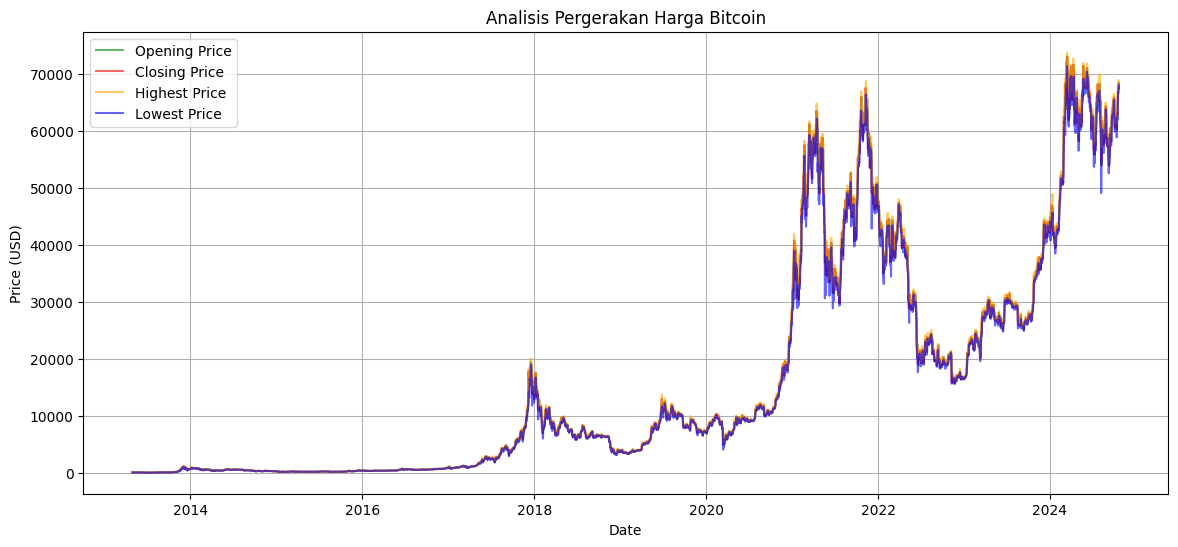

In [24]:
plt.figure(figsize=(14, 6))

plt.plot(mrg_df['date'], mrg_df['open'], label='Opening Price', color='green', alpha=0.6)
plt.plot(mrg_df['date'], mrg_df['close'], label='Closing Price', color='red', alpha=0.6)
plt.plot(mrg_df['date'], mrg_df['high'], label='Highest Price', color='orange', alpha=0.6)
plt.plot(mrg_df['date'], mrg_df['low'], label='Lowest Price', color='blue', alpha=0.6)

plt.title('Analisis Pergerakan Harga Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Dari visualisasi di atas nampak beberapa informasi di antaranya:
- **Tren Keseluruhan**: Terlihat adanya tren peningkatan harga Bitcoin secara umum selama periode tersebut.
- **Volatilitas**: Terdapat periode fluktuasi harga yang signifikan, menunjukkan volatilitas yang tinggi. Misalnya, peningkatan dan penurunan harga yang tajam dapat diamati pada rentang waktu tertentu, seperti di tahun 2021.
- **Hubungan antar harga**: Harga pembukaan, penutupan, tertinggi, dan terendah cenderung bergerak bersama-sama, yang mengindikasikan adanya korelasi antara berbagai aspek aktivitas harga harian Bitcoin.

### Volatilitas Perubahan Harga
Volatilitas adalah ukuran statistik yang menggambarkan tingkat perubahan atau fluktuasi harga suatu aset dalam periode waktu tertentu. Dalam konteks Bitcoin, volatilitas sering digunakan untuk mengukur risiko atau ketidakstabilan harga dari waktu ke waktu.

Untuk menghitung volatilitas harga Bitcoin, berikut langkah-langkahnya:
1. Perubahan Persentase Harga (Return): Perubahan harga harian dihitung menggunakan percentage change atau persentase perubahan harga penutupan dari satu hari ke hari berikutnya:

  \begin{equation}
  {P_t} = \frac{C_t - C_{t-1}}{C_{t-1}}
  \end{equation}

  Di mana:

  \begin{aligned}
  P_t & = \text{Return harian pada hari } t, \; \textit{persentase perubahan harga penutupan.}\\[10pt]
  C_t & = \text{Harga penutupan pada hari } t, \; \textit{harga Bitcoin di akhir hari perdagangan.}\\[10pt]
  C_{t-1} & = \text{Harga penutupan pada hari } t-1, \; \textit{harga Bitcoin di akhir hari sebelumnya.}
  \end{aligned}


2. Standar Deviasi dari Return: Untuk mengukur volatilitas, diperlukan menghitung standar deviasi dari return harian. Standar deviasi mengukur seberapa jauh perubahan harga harian bervariasi dari nilai rata-ratanya. Semakin besar standar deviasi, semakin tinggi volatilitas harga Bitcoin.

  \begin{equation}
  {\sigma} = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N} (R_i - \bar{R})^2}
  \end{equation}

  Di mana:

  \begin{aligned}
  \sigma & = \text{Standar deviasi dari return, mengukur volatilitas harga.}\\[10pt]
  N & = \text{Jumlah total observasi return (hari).}\\[10pt]
  R_i & = \text{Return harian pada hari ke-} i, \; \textit{perubahan persentase harga.}\\[10pt]
  \bar{R} & = \text{Rata-rata return harian, memberikan nilai tengah dari semua return.}
  \end{aligned}


3. Penyesuaian ke Periode Tertentu (Misalnya Mingguan, Bulanan): Untuk mengukur volatilitas dalam rentang waktu tertentu, misalnya mingguan atau bulanan, standar deviasi harian disesuaikan dengan mengalikan akar kuadrat dari jumlah hari dalam periode tersebut:

  \begin{equation}
  \text{Volatilitas Periodik} = \sigma \times \sqrt{T}
  \end{equation}

  Di mana:

  \begin{aligned}
  \text{Volatilitas Periodik} & = \text{Mengukur volatilitas dalam periode tertentu (mingguan, bulanan).}\\[10pt]
  \sigma & = \text{Standar deviasi dari return harian, menggambarkan volatilitas harian.}\\[10pt]
  T & = \text{Jumlah hari dalam periode yang dianalisis (contoh: 7 untuk mingguan, 30 untuk bulanan).}
  \end{aligned}

Secara keseluruhan, volatilitas memberikan gambaran seberapa besar perubahan harga Bitcoin dan membantu dalam memahami tingkat risiko dari fluktuasi harganya.

<br>

#### Jangka Pendek (7 Hari)

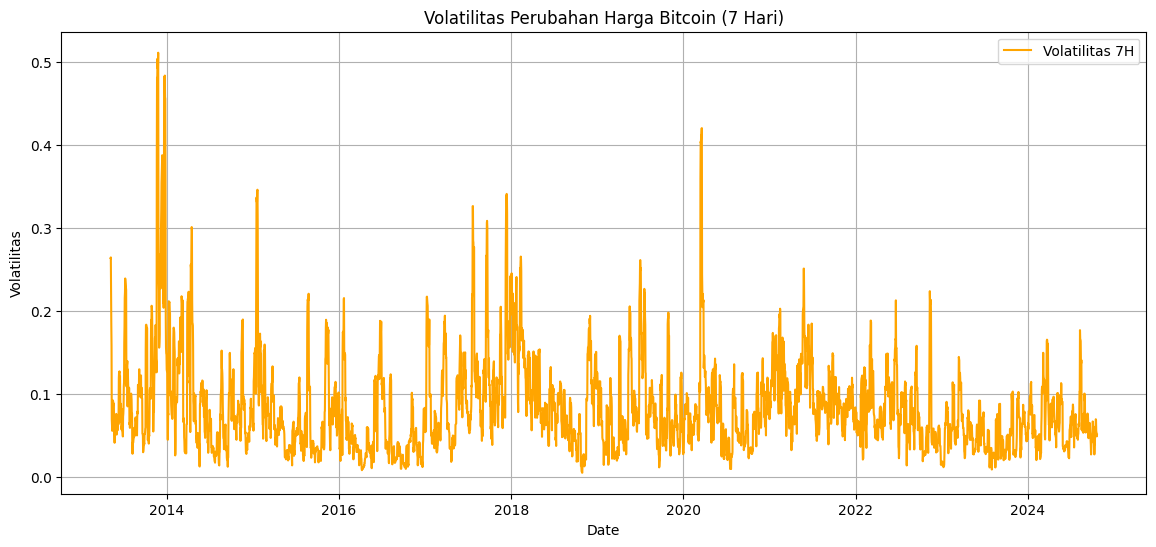

In [25]:
mrg_df['Volatilitas Mingguan'] = mrg_df['close'].pct_change().rolling(window=7).std() * np.sqrt(7)

plt.figure(figsize=(14, 6))
plt.plot(mrg_df['date'], mrg_df['Volatilitas Mingguan'], label='Volatilitas 7H', color='orange')
plt.title('Volatilitas Perubahan Harga Bitcoin (7 Hari)')
plt.xlabel('Date')
plt.ylabel('Volatilitas')
plt.legend()
plt.grid(True)
plt.show()

#### Jangka Menengah (30 Hari)

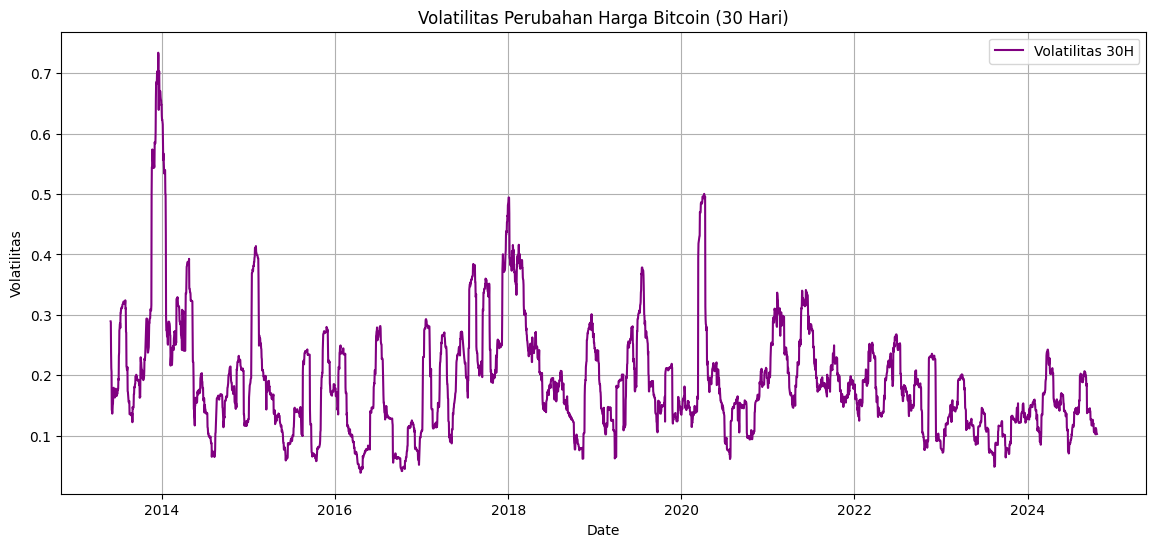

In [26]:
mrg_df['Volatilitas Bulanan'] = mrg_df['close'].pct_change().rolling(window=30).std() * np.sqrt(30)

plt.figure(figsize=(14, 6))
plt.plot(mrg_df['date'], mrg_df['Volatilitas Bulanan'], label='Volatilitas 30H', color='Purple')
plt.title('Volatilitas Perubahan Harga Bitcoin (30 Hari)')
plt.xlabel('Date')
plt.ylabel('Volatilitas')
plt.legend()
plt.grid(True)
plt.show()

#### Jangka Panjang (90 Hari)

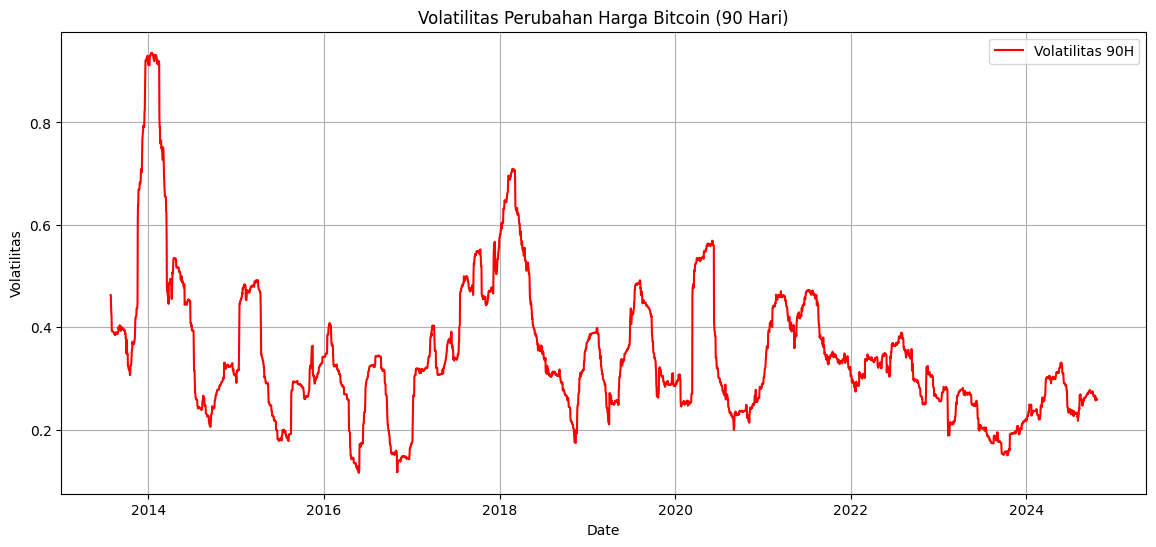

In [27]:
mrg_df['Volatilitas Jangka Panjang'] = mrg_df['close'].pct_change().rolling(window=90).std() * np.sqrt(90)

plt.figure(figsize=(14, 6))
plt.plot(mrg_df['date'], mrg_df['Volatilitas Jangka Panjang'], label='Volatilitas 90H', color='Red')
plt.title('Volatilitas Perubahan Harga Bitcoin (90 Hari)')
plt.xlabel('Date')
plt.ylabel('Volatilitas')
plt.legend()
plt.grid(True)
plt.show()

Dari ketiga visualisasi tingkat volatilitas harga Bitcoin tersebut didapatkan beberapa informasi di antaranya:
- Volatilitas Tinggi pada 2013-2014 dan 2017-2018: Terlihat lonjakan volatilitas yang signifikan pada periode tersebut, mengindikasikan fluktuasi harga Bitcoin yang besar. Periode tersebut bertepatan dengan bubble dan koreksi harga Bitcoin
- Volatilitas Menurun seiring Waktu: Secara umum, volatilitas Bitcoin cenderung menurun seiring waktu, meskipun masih terdapat periode dengan volatilitas tinggi
- Volatilitas Jangka Panjang lebih Stabil: Volatilitas 90 hari (jangka panjang) cenderung lebih stabil dibandingkan dengan volatilitas mingguan dan bulanan. Hal ini menunjukkan bahwa fluktuasi harga Bitcoin cenderung mereda dalam jangka waktu yang lebih panjang

### Rata-Rata Pergerakan Harga

Rata-rata Pergerakan Sederhana (Simple Moving Average - SMA) adalah metode perataan data harga dalam periode waktu tertentu untuk membantu mengidentifikasi tren dalam harga aset, seperti Bitcoin.

Perhitungan SMA dilakukan dengan cara mengambil rata-rata harga penutupan aset selama sejumlah hari tertentu, kemudian menggeser (rolling) jendela waktu tersebut setiap harinya untuk mendapatkan nilai SMA terbaru. Dengan cara ini, fluktuasi harga harian dapat dihaluskan sehingga tren harga lebih mudah dianalisis.

**Perhitungan SMA**

\begin{equation}
\text{SMA}n = \frac{C_t + C{t-1} + C_{t-2} + \dots + C_{t-n+1}}{n}
\end{equation}

Di mana:

\begin{aligned}
\text{SMA}_n & = \text{Simple Moving Average untuk periode } n \text{ hari.} \\[10pt]
C_t & = \text{Harga penutupan pada hari ke-} t.\\[10pt]
n & = \text{Jumlah hari dalam periode perhitungan SMA.}
\end{aligned}

Untuk SMA jangka pendek - menengah akan digunakan periode 50 hari, sedangkan untuk jangka panjang akan digunakan periode 200 hari.

**Mengapa 50 dan 200 Hari?**
- SMA-50 sering digunakan untuk mengukur tren jangka pendek hingga menengah. Periode 50 hari dianggap cukup untuk menunjukkan fluktuasi harga terbaru tanpa terlalu banyak "noise" dari pergerakan harga harian

- SMA-200 adalah indikator yang lebih umum digunakan untuk melihat tren jangka panjang. Periode ini cukup panjang untuk memberikan gambaran stabil tentang pergerakan harga dan menghilangkan fluktuasi harian yang tidak signifikan

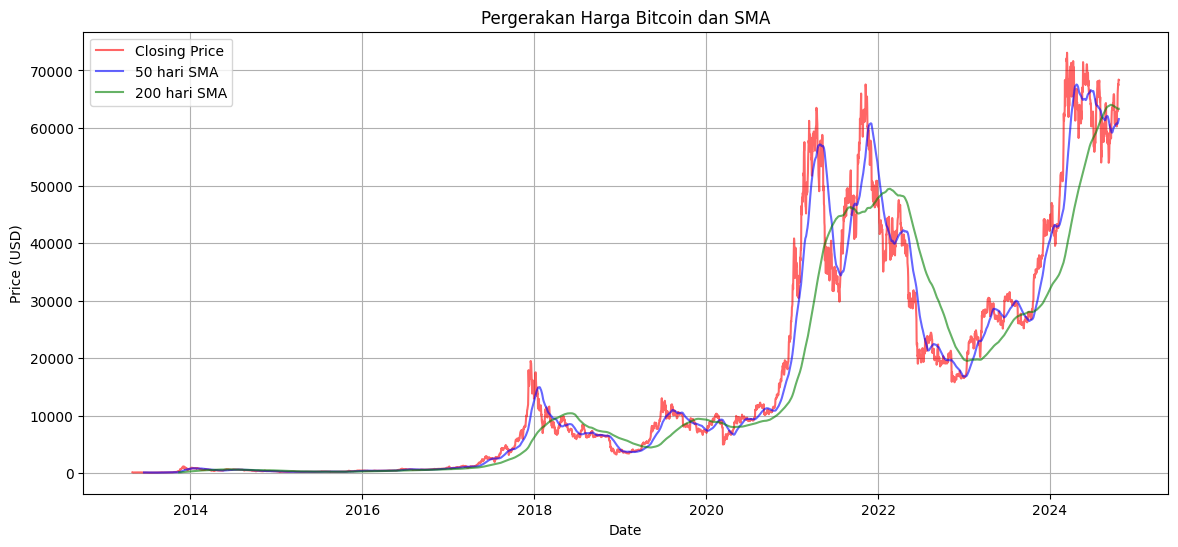

In [28]:
mrg_df['SMA-50'] = mrg_df['close'].rolling(window=50).mean()
mrg_df['SMA-200'] = mrg_df['close'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(mrg_df['date'], mrg_df['close'], label='Closing Price', color='red', alpha=0.6)

plt.plot(mrg_df['date'], mrg_df['SMA-50'], label='50 hari SMA', color='blue', alpha=0.6)
plt.plot(mrg_df['date'], mrg_df['SMA-200'], label='200 hari SMA', color='green', alpha=0.6)

plt.title('Pergerakan Harga Bitcoin dan SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Dari visualasi di atas, didapatkan informasi sebagai berikut:

SMA-200 bertindak sebagai support (level harga di mana tren penurunan cenderung berhenti) dalam jangka panjang, sedangkan SMA-50 bertindak sebagai support dan resistance (level harga di mana tren kenaikan cenderung berhenti) dalam jangka pendek dan menengah.

- Golden Cross: Ketika SMA-50 memotong SMA-200 dari bawah ke atas, ini menandakan potensi dimulainya tren kenaikan harga (bullish)
- Death Cross: Ketika SMA-50 memotong SMA-200 dari atas ke bawah, ini menandakan potensi dimulainya tren penurunan harga (bearish)

## Korelasi antara Harga Penutupan dengan Volume Transaksi

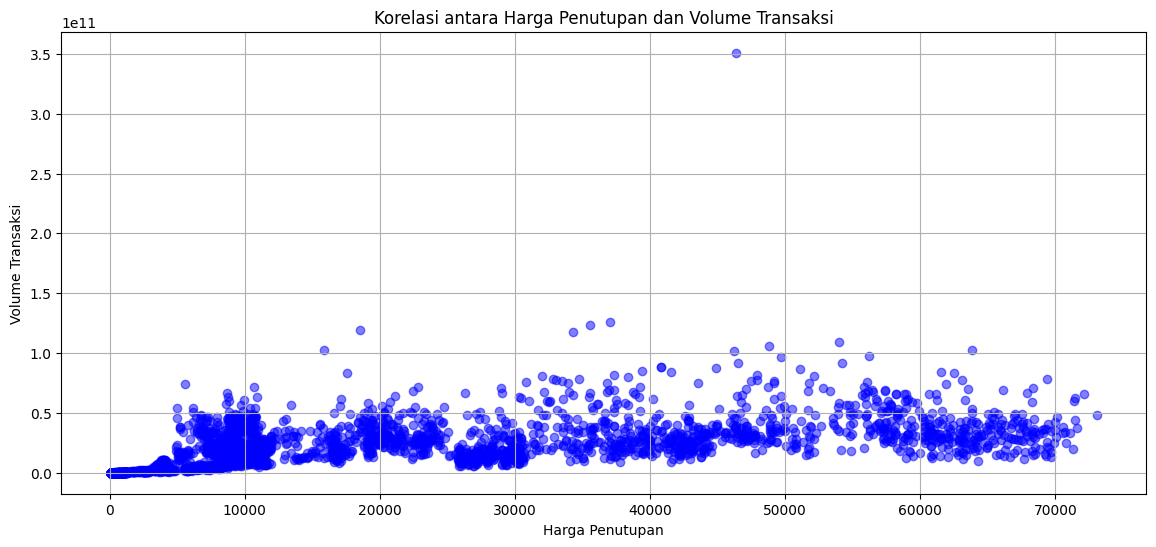

In [29]:
plt.figure(figsize=(14, 6))
plt.scatter(mrg_df['close'], mrg_df['volume'], alpha=0.5, color='blue')
plt.title('Korelasi antara Harga Penutupan dan Volume Transaksi')
plt.xlabel('Harga Penutupan')
plt.ylabel('Volume Transaksi')
plt.grid(True)
plt.show()

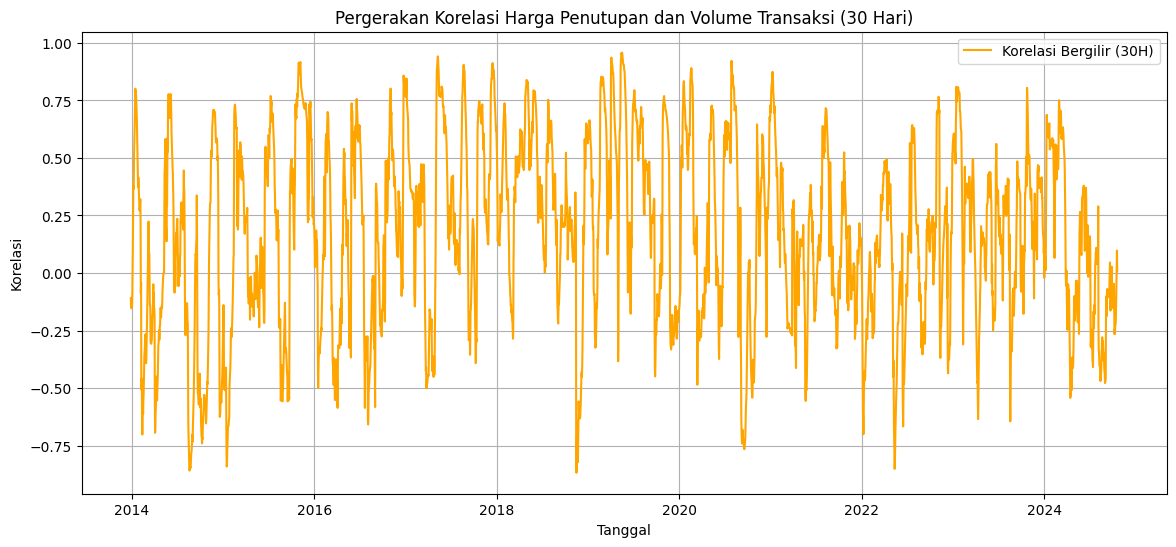


Nilai Korelasi antara Harga Penutupan dan Volume Transaksi: 0.67


In [30]:
mrg_df['Korelasi Bergilir (30 Hari)'] = mrg_df['close'].rolling(window=30).corr(mrg_df['volume'])

plt.figure(figsize=(14, 6))
plt.plot(mrg_df['date'], mrg_df['Korelasi Bergilir (30 Hari)'], label='Korelasi Bergilir (30H)', color='orange')
plt.title('Pergerakan Korelasi Harga Penutupan dan Volume Transaksi (30 Hari)')
plt.xlabel('Tanggal')
plt.ylabel('Korelasi')
plt.legend()
plt.grid(True)
plt.show()

# Menghitung korelasi harga penutupan dan volume
corl = mrg_df['close'].corr(mrg_df['volume'])
print(f'\nNilai Korelasi antara Harga Penutupan dan Volume Transaksi: {corl:.2f}')

Dari kedua visualisasi di atas an hasil perhitungan korelasi, didapatkan informasi sebagai berikut:
- Sebaran titik-titik pada scatter plot menunjukkan adanya ketidaklinearan dalam hubungan antara harga dan volume. Titik-titik tidak membentuk pola garis lurus yang jelas, mengindikasikan faktor-faktor lain mungkin memengaruhi volume selain dari harga, seperti sentimen pasar, berita, dan regulasi, juga dapat memengaruhi volume transaksi Bitcoin dan perlu dipertimbangkan dalam analisis yang lebih komprehensif
- Meskipun umumnya positif, korelasi antara harga penutupan dan volume transaksi tidak selalu konsisten, ditunjukkan oleh fluktuasi pada grafik korelasi bergilir. Terdapat periode di mana korelasi melemah atau bahkan berbalik arah
- Nilai korelasi 0.67 menunjukkan hubungan yang cukup kuat, namun ketidaklinearan pada scatter plot mengingatkan kita bahwa korelasi tidak selalu berarti hubungan sebab-akibat yang sederhana

Setelah visualisasi selesai, kolom-kolom yang sudah tidak diperlukan seperti Volatilitas Mingguan, Volatilitas Bulanan, Volatilitas Jangka Panjang, SMA-50, SMA-200, Korelasi Bergilir (30 Hari) akan dihapus.

In [31]:
mrg_df.drop(['Volatilitas Mingguan', 'Volatilitas Bulanan', 'Volatilitas Jangka Panjang', 'SMA-50', 'SMA-200', 'Korelasi Bergilir (30 Hari)'], axis=1, inplace=True)

## 4. Data Preparation

Pada bagian ini akan dilakukan beberapa persiapan data yaitu:

### 4.1. Membagi Feature dan Target serta Shifting Data
Dalam rangka memprediksi harga Bitcoin untuk 5 hari ke depan, langkah pertama adalah membagi feature dan target. Numerical feature yang digunakan terdiri dari kolom high, low, open, close, volume, dan marketcap. Target merupakan prediksi harga penutupan (closing price) Bitcoin pada hari ke-5 setelah data pada hari yang sedang diproses. Untuk menetapkan kolom target ini, digunakan teknik shifting, di mana data harga penutupan bergeser sebanyak 5 hari ke depan.



In [32]:
# Menambahkan kolom target prediksi 5 hari ke depan
mrg_df['Prediction_5D'] = mrg_df['close'].shift(-5)

In [33]:
mrg_df

,date,high,low,open,close,volume,marketcap,Prediction_5D
0,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,112.500000
1,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,115.910004
2,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,112.300003
3,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,111.500000
4,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,113.566002
...,...,...,...,...,...,...,...,...
4186,2024-10-15 23:59:59,67881.679587,64809.196947,66050.368727,67041.107165,4.886387e+10,1.325307e+12,NaN
4187,2024-10-16 23:59:59,68375.292949,66758.725509,67042.461822,67612.720778,3.819519e+10,1.336697e+12,NaN
4188,2024-10-17 23:59:59,67912.207640,66647.391211,67617.079571,67399.833492,3.279090e+10,1.332817e+12,NaN
4189,2024-10-18 23:59:59,68969.746924,67177.818199,67419.108725,68418.789049,3.685717e+10,1.352611e+12,NaN


Setelah itu, fitur numerik perlu dimundurkan 5 hari agar selaras dengan target prediksi. Hal ini dilakukan untuk memastikan bahwa model menggunakan data dari 5 hari sebelumnya sebagai dasar prediksi harga di masa depan.

In [34]:
mrg_df['high_shifted'] = mrg_df['high'].shift(5)
mrg_df['low_shifted'] = mrg_df['low'].shift(5)
mrg_df['open_shifted'] = mrg_df['open'].shift(5)
mrg_df['volume_shifted'] = mrg_df['volume'].shift(5)
mrg_df['marketcap_shifted'] = mrg_df['marketcap'].shift(5)

In [35]:
mrg_df.dropna(subset=['high_shifted', 'low_shifted', 'open_shifted', 'volume_shifted', 'marketcap_shifted', 'Prediction_5D'], inplace=True)
mrg_df[['high_shifted', 'low_shifted', 'open_shifted', 'volume_shifted', 'marketcap_shifted', 'Prediction_5D']].isna().sum()

,0
high_shifted,0
low_shifted,0
open_shifted,0
volume_shifted,0
marketcap_shifted,0
Prediction_5D,0


In [36]:
# Menampilkan dataframe hasil shifting
shifted_df = mrg_df[['high_shifted', 'low_shifted', 'open_shifted', 'volume_shifted', 'marketcap_shifted', 'Prediction_5D']]

shifted_df

,high_shifted,low_shifted,open_shifted,volume_shifted,marketcap_shifted,Prediction_5D
5,147.488007,134.000000,134.444000,0.000000e+00,1.603769e+09,112.669998
6,146.929993,134.050003,144.000000,0.000000e+00,1.542813e+09,117.199997
7,139.889999,107.720001,139.000000,0.000000e+00,1.298955e+09,115.242996
8,125.599998,92.281898,116.379997,0.000000e+00,1.168517e+09,115.000000
9,108.127998,79.099998,106.250000,0.000000e+00,1.085995e+09,117.980003
...,...,...,...,...,...,...
4181,62371.023679,61689.581165,62067.610497,1.330541e+10,1.227022e+12,67041.107165
4182,62959.568541,61833.150043,62084.986501,1.477623e+10,1.241559e+12,67612.720778
4183,64443.706412,62152.551708,62819.109333,3.425356e+10,1.229782e+12,67399.833492
4184,63174.306200,61843.563661,62221.645149,2.813448e+10,1.228038e+12,68418.789049


Pemunduran fitur ini penting untuk mencegah kebocoran data, di mana model dapat "melihat" informasi dari masa depan yang seharusnya belum tersedia. Pendekatan ini sesuai dengan prinsip dalam analisis time series, di mana variabel input (fitur) harus mencerminkan periode waktu sebelum variabel target. Setelah dilakukan pemunduran data dan menghapus nilai null, kini terdapat total 4,181 baris data yang siap untuk digunakan dalam model.

### 4.2 Split Dataset

In [37]:
X = mrg_df[['high_shifted', 'low_shifted', 'open_shifted', 'volume_shifted', 'marketcap_shifted']]
y = mrg_df['Prediction_5D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3344, 5)
X_test shape: (837, 5)
y_train shape: (3344,)
y_test shape: (837,)


## 5. Model Development

Pada tahap ini menggunakan algoritma machine learning XGBoost dengan menerapkan hyperparameter tuning untuk mencari nilai learning rate, max_depth, subsample, dan n_estimators terbaik.

Model yang sudah dilatih akan dievaluasi dengan metrik MAE dan MSE.
<br>




In [38]:
# Normalisasi fitur
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [39]:
# Normalisasi variabel target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [40]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_scaled, y_train_scaled)

y_xgb_pred_scaled = xgb_model.predict(X_test_scaled)

In [46]:
y_xgb_pred = scaler_y.inverse_transform(y_xgb_pred_scaled.reshape(-1, 1))

xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_mae = mean_absolute_error(y_test, y_xgb_pred)

print(f'Mean Squared Error: {xgb_mse:.2f}')
print(f'Mean Absolute Error: {xgb_mae:.2f}')

Mean Squared Error: 6978760.79
Mean Absolute Error: 1242.54


Dari informasi di atas, didapatkan Mean Squared Error (MSE) sebesar 6.978.760.79 dan Mean Absolute Error (MAE) sebesar 1.242.54, yang menggambarkan tingkat kesalahan prediksi dalam model ini. Dengan MAE sebesar 1.242.54, ini berarti rata-rata prediksi harga Bitcoin meleset sekitar 1.242 USD dari harga sebenarnya. Mengingat volatilitas harga Bitcoin yang tinggi, kesalahan ini masih dalam batas wajar, terutama jika mempertimbangkan bahwa fluktuasi harga BTC bisa mencapai ribuan dolar dalam satu hari.

Namun, MSE yang lebih tinggi menunjukkan adanya outlier atau prediksi dengan kesalahan yang lebih besar. Untuk meningkatkan akurasi model dan mengurangi kesalahan prediksi, langkah selanjutnya adalah melakukan hyperparameter tuning.

### Hyperparameter Tuning

Hyperparameter tuning adalah sebuah proses untuk melakukan optimalisasi parameter pada sebuah model. Untuk proyek ini Parameter yang di gunakan ada 4 yaitu :

- learning_rate: Mengontrol tingkat di mana model belajar dari setiap iterasi. Nilai yang terlalu besar dapat menyebabkan overfitting, sedangkan nilai yang terlalu kecil dapat memperlambat konvergensi.
- max_depth: Mengontrol kedalaman maksimum pohon keputusan. Nilai yang terlalu besar dapat menyebabkan overfitting, sedangkan nilai yang terlalu kecil dapat menghambat kemampuan model untuk menangkap pola yang kompleks.
- subsample: Mengontrol proporsi data yang digunakan untuk membangun setiap pohon keputusan. Subsampling dapat membantu mengurangi overfitting.
- n_estimators: Menentukan jumlah pohon keputusan yang akan dibangun. Jumlah pohon yang terlalu sedikit dapat menyebabkan underfitting, sedangkan jumlah pohon yang terlalu banyak dapat menyebabkan overfitting.

Proses hyperparameter tuning akan dilakukan menggunakan teknik Grid Search yang bertujuan untuk melakukan validasi untuk lebih dari satu model dan hyperparameter masing-masing secara otomatis dan sistematis.

In [44]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


Berdasarkan informasi di atas, algoritma XGBoost memperoleh parameter terbaik yaitu learning_rate = 0.1, max_depth = 5, n_estimators = 100, dan subsample = 1.0

In [48]:
xgb_best_model = xgb.XGBRegressor(**best_params)
xgb_best_model.fit(X_train_scaled, y_train_scaled)

y_best_pred_scaled = xgb_best_model.predict(X_test_scaled)

y_best_pred = scaler_y.inverse_transform(y_best_pred_scaled.reshape(-1, 1))
best_mse= mean_squared_error(y_test, y_best_pred)
best_mae= mean_absolute_error(y_test, y_best_pred)

print(f'Mean Squared Error (tuning): {best_mse:.2f}')
print(f'Mean Absolute Error (tuning): {best_mae:.2f}')

Mean Squared Error (tuning): 6450337.21
Mean Absolute Error (tuning): 1222.15


Nilai akurasi model meningkat setelah diterapkan hyperparameter tuning dengan perolehan nilai Mean Squared Error: 6.450.337.21 dan Mean Absolute Error: 1.222.15. Tentunya performa model lebih baik jika dibandingkan dengan akurasi sebelum dilakukan tuning.

## 6. Model Evaluation
Seperti yang telah dijelaskan sebelumnya, metrik evaluasi yang digunakan adalah Mean Absolute Error (MAE) dan Mean Square Error (MSE).

**Kenapa MAE dan MSE?**
<br>
MAE dan MSE adalah dua metrik yang umum digunakan untuk mengukur kinerja model regresi, termasuk model XGBoost. Keduanya mengukur seberapa jauh prediksi model dari nilai sebenarnya, namun dengan cara yang sedikit berbeda.

- Mean Absolute Error (MAE)

  MAE adalah metrik yang mengukur rata-rata selisih absolut antara nilai prediksi model dengan nilai aktual. Dengan kata lain, MAE menghitung rata-rata dari nilai absolut perbedaan antara nilai yang diprediksi oleh model dengan nilai sebenarnya. Nilai MAE yang lebih kecil menunjukkan bahwa model semakin akurat dalam membuat prediksi.
  
  MAE memiliki keunggulan karena lebih robust terhadap outlier dibandingkan dengan MSE. Artinya, nilai outlier tidak akan terlalu memengaruhi nilai MAE secara signifikan.
  
  MAE sering digunakan ketika kita ingin mendapatkan gambaran umum tentang seberapa besar kesalahan model secara rata-rata

  \begin{equation}
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  \end{equation}

  Di mana:

  \begin{aligned}
  \text{MAE} & = \text{Mean Absolute Error} \\[10pt]
  n & = \text{Jumlah data observasi} \\[10pt]
  y_i & = \text{Nilai aktual ke-} i \\[10pt]
  \hat{y}_i & = \text{Nilai prediksi ke-} i
  \end{aligned}

- Mean Squared Error (MSE)

  MSE adalah metrik lain yang populer untuk mengukur kinerja model regresi. MSE menghitung rata-rata kuadrat dari selisih antara nilai prediksi dan nilai aktual.
  
  Dengan mengkuadratkan selisih, MSE memberikan bobot yang lebih besar pada kesalahan yang besar. Ini berarti bahwa model akan lebih "dihukum" jika membuat prediksi yang jauh dari nilai sebenarnya.
  
  MSE sering digunakan ketika kita ingin memberikan penalti yang lebih besar pada kesalahan yang besar, karena kesalahan yang besar dapat memiliki konsekuensi yang lebih signifikan.

  \begin{equation}
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  \end{equation}

  Di mana:

  \begin{aligned}
  \text{MSE} & = \text{Mean Squared Error} \\[10pt]
  n & = \text{Jumlah data observasi} \\[10pt]
  y_i & = \text{Nilai aktual ke-} i \\[10pt]
  \hat{y}_i & = \text{Nilai prediksi ke-} i
  \end{aligned}

### Perbandingan Performa dengan Baseline

In [49]:
print(f'Mean Squared Error: {xgb_mse:.2f}')
print(f'Mean Absolute Error: {xgb_mae:.2f}')

Mean Squared Error: 6978760.79
Mean Absolute Error: 1242.54


Pada tahap awal, model dilatih tanpa melakukan hyperparameter tuning, menghasilkan nilai Mean Squared Error (MSE) sebesar 6.978.760,79 dan Mean Absolute Error (MAE) sebesar 1.242,54. Hasil ini menunjukkan bahwa model sudah cukup baik dalam memprediksi harga, namun masih terdapat ruang untuk perbaikan dalam hal akurasi prediksi.

In [50]:
print(f'Mean Squared Error (tuning): {best_mse:.2f}')
print(f'Mean Absolute Error (tuning): {best_mae:.2f}')

Mean Squared Error (tuning): 6450337.21
Mean Absolute Error (tuning): 1222.15


Setelah melakukan tuning, model mengalami peningkatan performa dengan MSE menurun menjadi 6.450.337,21 dan MAE turun menjadi 1.222,15. Penurunan ini menunjukkan bahwa model mampu lebih baik dalam menyesuaikan hyperparameter untuk mengurangi kesalahan prediksi.

### Harga Aktual vs Prediksi

Dalam analisis ini, kita akan membandingkan harga aktual Bitcoin dengan harga yang diprediksi oleh model XGBoost melalui visualisasi scatterplot. Visualisasi ini tidak hanya memungkinkan kita untuk melihat sejauh mana prediksi model sejalan dengan data aktual, tetapi juga membantu kita mengidentifikasi pola dan outlier yang mungkin ada.

In [60]:
y_best_pred_scaled = xgb_best_model.predict(X_test_scaled)
y_best_pred = scaler_y.inverse_transform(y_best_pred_scaled.reshape(-1, 1))

comparison_df = pd.DataFrame({'Aktual': y_test, 'Prediksi': y_best_pred.flatten()})

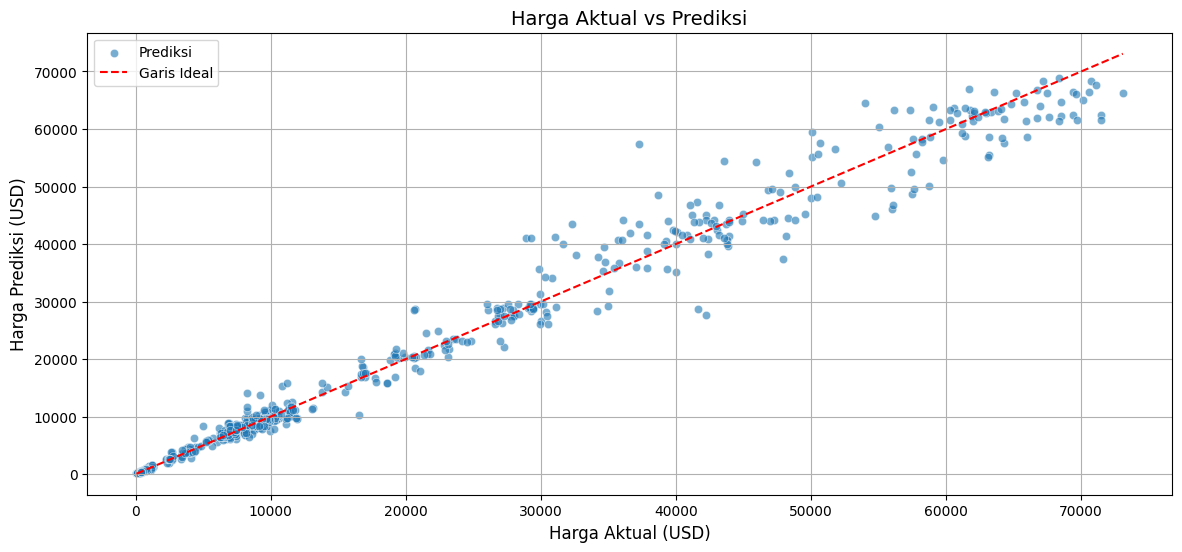

In [66]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=comparison_df['Aktual'], y=comparison_df['Prediksi'], alpha=0.6, label='Prediksi')
plt.plot([comparison_df['Aktual'].min(), comparison_df['Aktual'].max()],
         [comparison_df['Aktual'].min(), comparison_df['Aktual'].max()],
         color='red', linestyle='--', label='Garis Ideal')
plt.title('Harga Aktual vs Prediksi', fontsize=14)
plt.xlabel('Harga Aktual (USD)', fontsize=12)
plt.ylabel('Harga Prediksi (USD)', fontsize=12)
plt.grid()
plt.legend(loc='upper left')
plt.show()

Dari visualiasi di atas didapatkan informasi sebagai berikut:

- Meskipun ada beberapa titik data yang melenceng dari garis ideal, tetapi secara keseluruhan sebaran titik-titik pada grafik harga aktual vs harga prediksi menunjukkan bahwa prediksi model XGBoost cukup akurat dan mengikuti tren harga aktual dengan baik.

- Namun, perlu diingat bahwa model tetap memiliki keterbatasan dan prediksi harga Bitcoin di dunia nyata dipengaruhi oleh banyak faktor kompleks yang mungkin tidak sepenuhnya tercakup dalam model, seperti sentimen pasar, regulasi pemerintah, dan berita terkait Bitcoin.

### Prediksi Harga 5 Hari ke Depan

In [68]:
last_features = mrg_df[['high_shifted', 'low_shifted', 'open_shifted', 'volume_shifted', 'marketcap_shifted']].iloc[-5:]
last_features_scaled = scaler_X.transform(last_features)

pred_xgb_scaled = xgb_best_model.predict(last_features_scaled)
pred_xgb = scaler_y.inverse_transform(pred_xgb_scaled.reshape(-1, 1))

last_date = pd.to_datetime('2024-10-19')

predicted_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 6)]

predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted (XGBoost)': pred_xgb.flatten()
})

In [69]:
predictions_df

,Date,Predicted (XGBoost)
0,2024-10-20,66114.976562
1,2024-10-21,67200.789062
2,2024-10-22,64347.089844
3,2024-10-23,66573.289062
4,2024-10-24,61312.945312


Berdasarkan model XGBoost yang telah dituning, prediksi harga Bitcoin untuk periode 20 hingga 24 Oktober 2024 menunjukkan fluktuasi harga yang bervariasi. Pada tanggal 20 Oktober, harga diperkirakan mencapai sekitar \$66,115, yang kemudian mengalami kenaikan menjadi \$67,201 pada tanggal 21 Oktober. Namun, harga mengalami penurunan pada tanggal 22 Oktober, dengan prediksi sekitar \$64,347.

Prediksi kembali menunjukkan tren pemulihan pada tanggal 23 Oktober, dengan estimasi harga \$66,573, sebelum mengalami penurunan lagi menjadi \$61,313 pada tanggal 24 Oktober. Fluktuasi harga ini mencerminkan dinamika pasar yang mungkin dipengaruhi oleh faktor eksternal, seperti berita industri atau perubahan sentimen pasar.

Secara keseluruhan, hasil prediksi ini memberikan insight penting bagi investor dan trader untuk merencanakan strategi perdagangan mereka berdasarkan proyeksi harga Bitcoin dalam jangka pendek.